In [1]:
# Install required libraries (if not already installed)
!pip install yfinance


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


[*********************100%***********************]  1 of 1 completed


Price      Adj Close     Close      High       Low      Open     Volume
Ticker          AAPL      AAPL      AAPL      AAPL      AAPL       AAPL
Date                                                                   
2010-01-04  6.447413  7.643214  7.660714  7.585000  7.622500  493729600
2010-01-05  6.458561  7.656429  7.699643  7.616071  7.664286  601904800
2010-01-06  6.355827  7.534643  7.686786  7.526786  7.656429  552160000
2010-01-07  6.344076  7.520714  7.571429  7.466071  7.562500  477131200
2010-01-08  6.386253  7.570714  7.571429  7.466429  7.510714  447610800


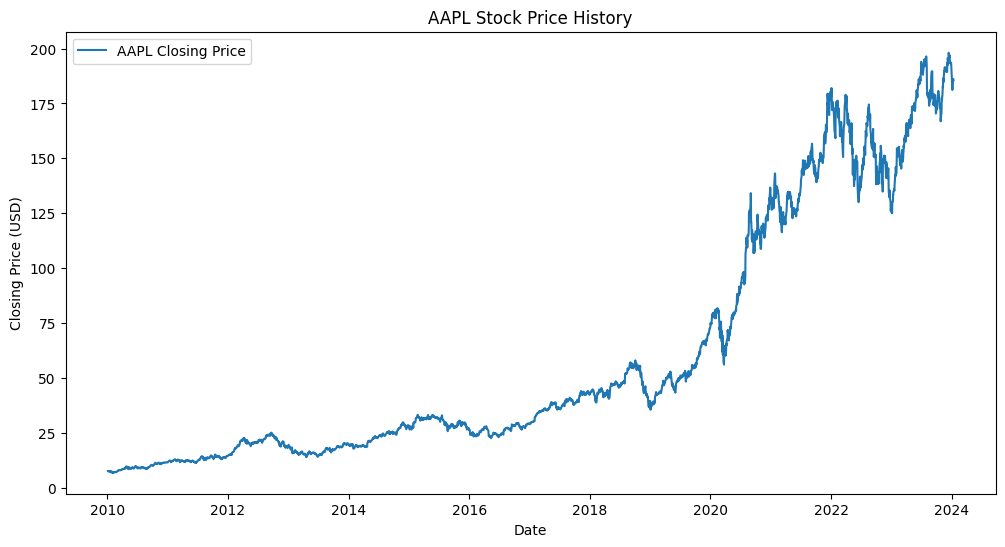

In [4]:
# Download stock data
stock_symbol = 'AAPL'  # Apple stock as an example
data = yf.download(stock_symbol, start='2010-01-01', end='2024-01-12')

# View the dataset
print(data.head())

# Plot the closing price
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label=f'{stock_symbol} Closing Price')
plt.title(f'{stock_symbol} Stock Price History')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.show()


In [5]:
# Normalize the 'Close' price
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Create sequences (e.g., 60 days of data to predict the next day)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Reshape X for LSTM input
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split into training and testing datasets
train_size = int(0.8 * len(X))
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]


In [6]:
# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Display the model architecture
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

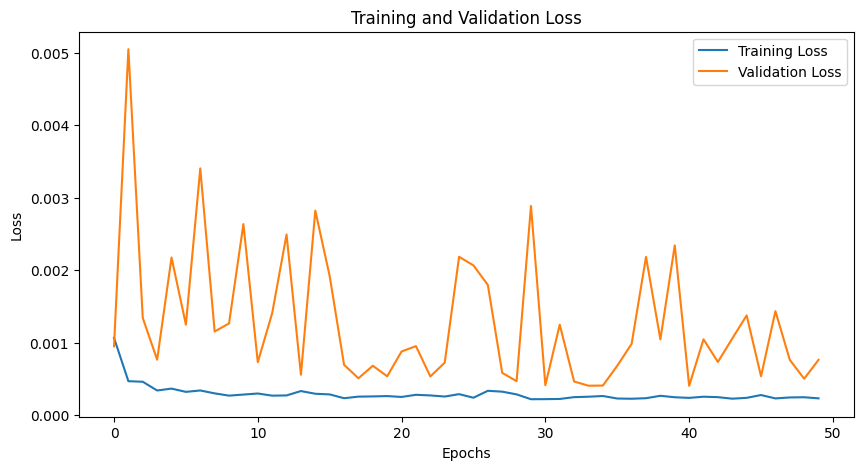

In [11]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [7]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.0020 - val_loss: 9.4787e-04
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 5.5719e-04 - val_loss: 0.0050
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - loss: 5.6627e-04 - val_loss: 0.0013
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 3.8432e-04 - val_loss: 7.6344e-04
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 3.3651e-04 - val_loss: 0.0022
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 3.6305e-04 - val_loss: 0.0012
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 3.5338e-04 - val_loss: 0.0034
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - loss: 2.9775e-04 - val_loss: 0.0012
Epoch 9/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 2.6904e-04 - val_loss: 0.0013
Epoch 10/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 2.7284e-04 - val_loss: 0.0026
Epoch 11/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 3.0355e-04 - val_loss: 7.2930e-04
Epoch 12/5

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


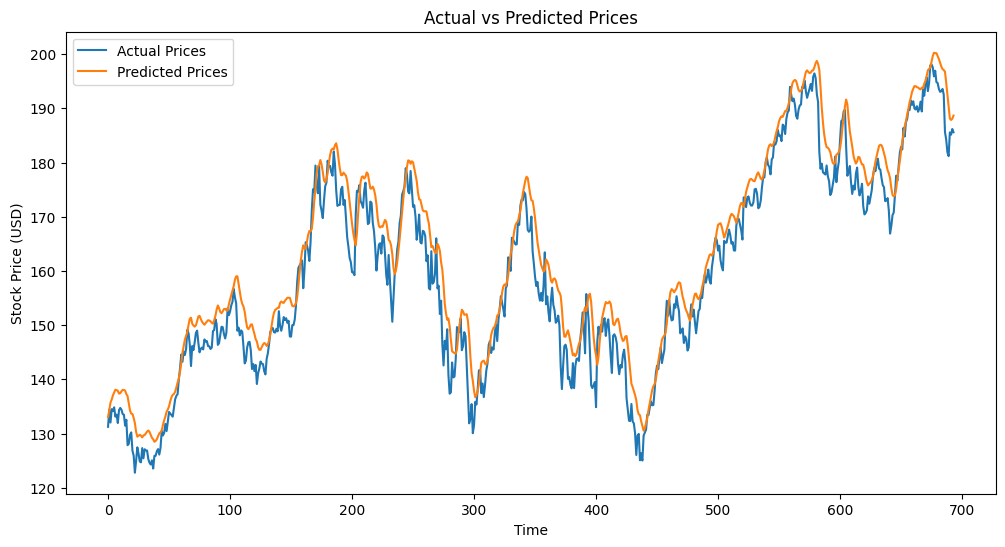

In [8]:
# Predict on test data
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Rescale actual prices for comparison
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Prices')
plt.plot(predicted_prices, label='Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()


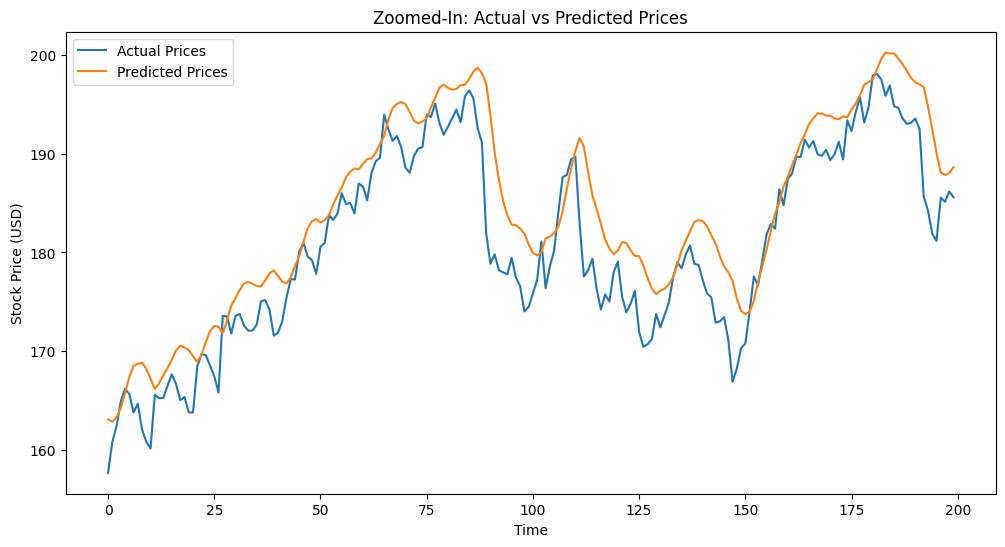

In [12]:
# Zoomed-in comparison of actual and predicted prices
plt.figure(figsize=(12, 6))
plt.plot(actual_prices[-200:], label='Actual Prices')
plt.plot(predicted_prices[-200:], label='Predicted Prices')
plt.title('Zoomed-In: Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()


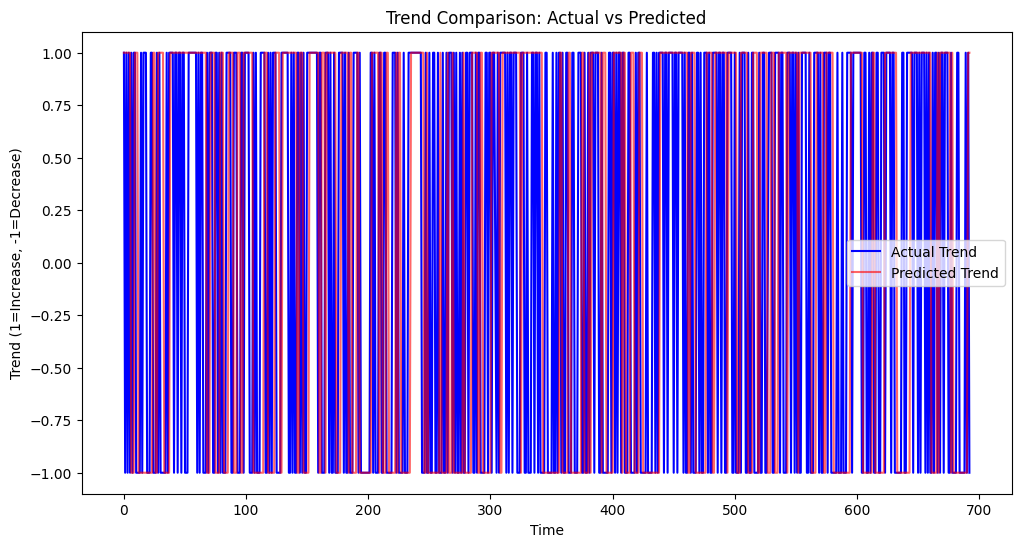

In [13]:
# Highlight trends
actual_trend = np.sign(np.diff(actual_prices.flatten()))
predicted_trend = np.sign(np.diff(predicted_prices.flatten()))

# Plot trend comparison
plt.figure(figsize=(12, 6))
plt.plot(actual_trend, label='Actual Trend', color='blue')
plt.plot(predicted_trend, label='Predicted Trend', color='red', alpha=0.6)
plt.title('Trend Comparison: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Trend (1=Increase, -1=Decrease)')
plt.legend()
plt.show()


In [9]:
# Save the model
model.save('lstm_stock_predictor.h5')

# Load the model (if needed later)
from tensorflow.keras.models import load_model
loaded_model = load_model('lstm_stock_predictor.h5')


In [10]:
# Predict on new data (e.g., future prices)
new_data = scaled_data[-seq_length:]  # Use the last available data for prediction
new_data = new_data.reshape(1, seq_length, 1)
future_price = model.predict(new_data)
future_price = scaler.inverse_transform(future_price)
print(f'Predicted future price: {future_price[0][0]} USD')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted future price: 189.05482482910156 USD
